# Data Smart Sans Excel

[Table of Contents](Data%20Smart%20Sans%20Excel.ipynb)

If you have not downloaded the Data Smart files then run the first code block of the main notebook and it will download the files from the web. 

## Chapter 2 - K-means Clustering

In [156]:
import pandas as pd
import numpy as np
import os
excel_file = os.path.join(os.getcwd(), "data_smart_files", "ch02", "WineKMC.xlsx")
offer_info_df = pd.read_excel(excel_file, 'OfferInformation', index_col=0)

transactions_df = pd.read_excel(excel_file, 'Transactions')
order_info_df = pd.read_excel(excel_file, 'OfferInformation')
order_info_df.set_index('Offer #', drop=True, inplace=True)

transactions_pt = pd.pivot_table(transactions_df,index=["Offer #"],columns=["Customer Last Name"],
                    values=['Offer #'],aggfunc=[np.count_nonzero],fill_value=0)
#for some reason an extra 1 was being added to each nonzero count, so i subtracted 1.
transactions_pt = transactions_pt.applymap(lambda x: max(0,x-1))
transactions_np = transactions_pt.values

We now have the details about the offers in a dataframe along with which customers bought which deals.
Next we want to solve for our K clusters by minimizing the distance between the cluster centers and the cluster members.

In the code below:
* X is the dataset where a row is a single data point, shape=(n_samples, n_features)
* idx is the centroid assignment vector (each entry is a cluster b/t 0 and K)
* K = number of clusters

### K-Cluster Code

In [304]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec 
import time

# Note: some of the below code was generated during Andrew Ng's Machine Learning class. 
# It likely includes some of the starter code he provided. 

def distance(X, centroids, K):
    X = X.T
    distance = np.zeros((centroids.shape[0], X.shape[1]))
    for i in range(0, K):
        distance[i, :] = np.sqrt((np.apply_along_axis(lambda x: x ** 2, 0,
                                                      (X.T - centroids[i]))).sum(axis=1))
    dist_min = np.min(distance, axis=0)
    total_dist = np.sum(dist_min)
    return total_dist

def plot_init(max_iters, m, n, K):
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Total Distance')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Clusters')
    ax1.set_xlim(-0.5, n - 0.5)
    ax1.set_ylim(-0.5, K - 0.5)
    return fig, [ax0, ax1]

def runkMeans(X, initial_centroids, max_iters, plot_progress=False, binary=False):
    # runs the K-Means algorithm on data matrix X, where each
    # row of X is a single example. It uses initial_centroids as the
    # initial centroids. max_iters specifies the total number of iterations
    # of K-Means to execute. plot_progress is a true/false flag that
    # indicates if the function should also plot its progress as the
    # learning happens. This is set to false by default. runkMeans returns
    # centroids, a Kxn matrix of the computed centroids and idx, a m x 1
    # vector of centroid assignments (i.e. each entry in range [1..K])

    m, n = X.shape
    K = np.array(initial_centroids).shape[0]
    centroids = initial_centroids
    idx = np.zeros((m, 1))
    d = []
    # Run K-Means
    if plot_progress:
        fig, [ax0, ax1] = plot_init(max_iters, m, n, K)
        x_values = np.linspace(0, max_iters, max_iters)
        y_values = np.zeros(max_iters)

    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids, binary)
        # compute new centroids
        centroids = computeCentroids(X, idx, K, binary)
        di = distance(X, centroids, K)
        if plot_progress:
            # Left Plot
            y_values[i] = di
            if len(ax0.lines):
                ax0.lines[0].set_xdata(x_values)
                ax0.lines[0].set_ydata(y_values)
            else:
                ax0.plot(x_values, y_values)

            # Right Plot
            plt.imshow(centroids, cmap='OrRd', interpolation='nearest', aspect='auto')
            ax1.xaxis.set_major_formatter(ticker.NullFormatter())
            x_ticks = list(range(centroids.shape[1]))
            if len(x_ticks) > 5:
                def f(x):
                    if np.mod(x, 2) == 0:
                        return ''
                    else:
                        return str(x + 1)
            else:
                def f(x):
                    return str(x + 1)
            x_tick_lables = list(map(f, x_ticks))
            ax1.xaxis.set_minor_locator(ticker.FixedLocator(x_ticks))
            ax1.xaxis.set_minor_formatter(ticker.FixedFormatter(x_tick_lables))
            ax1.yaxis.set_major_formatter(ticker.NullFormatter())
            y_ticks = list(range(K))
            y_tick_lables = list(map(lambda x: str(x + 1), y_ticks))
            ax1.yaxis.set_minor_locator(ticker.FixedLocator(y_ticks))
            ax1.yaxis.set_minor_formatter(ticker.FixedFormatter(y_tick_lables))
            plt.tight_layout()
            fig.canvas.draw()
            time.sleep(.05)
    return [centroids, idx, di]

def computeCentroids(X, idx, K, binary=False):
    # returns the new centroids by computing the means of the data points assigned
    # to each centroid. It is given a dataset X where each row is a single data point,
    # a vector idx of centroid assignments (i.e. each entry in range [1..K]) for each
    # example, and K, the number of centroids.
    #
    # Return a matrix of centroids, where each row of centroids is the mean of the data
    # points assigned to it.

    m, n = X.shape
    centroids = np.zeros((K, n))
    for cluster in range(K):
        # xi contains samples that belog to cluster
        xi = X[np.where(idx == cluster)[0]]
        # ck is the number of samples int he cluster
        ck = max(xi.shape[0], 1)
        centroids[cluster] = np.sum(xi, 0) / ck
    if binary:
        return np.round(centroids)
    else:
        return centroids

def findClosestCentroids(X, centroids, binary=False):
    # computes the centroid memberships for every example
    # function returns the closest centroids in idx
    # for a dataset X where each row is a single example. idx = m x 1
    # vector of centroid assignments (i.e. each entry in range [1..K])

    K = len(centroids)
    m, n = X.shape
    idx = np.zeros((m, 1))
    if binary:
        def div(a, b):
            if b == 0:
                return 0
            else:
                return a / b
        d1 = np.dot(X, centroids.T)
        d2 = np.dot(np.sqrt(np.sum(X, axis=1)).reshape(m, 1),
                    np.sqrt(np.sum(centroids, axis=1)).reshape((1, K)))
        div_v = np.vectorize(div)
        d = 1 - div_v(d1, d2)
        idx[:, 0] = np.argmin(d, axis=1)
        return idx
    else:
        for i in range(m):
            x = X[i]
            winner = 10 ** 1000
            for j in range(K):
                c = centroids[j]
                d = np.dot(x - c, x - c)
                if d < winner:
                    winner = d
                    idx[i] = j
        return idx

def kMeansInitCentroids(X, K):
    # returns K initial centroids to be used with the K-Means on the dataset X
    # K number of random samples are used for the initial centroids

    m, n = X.shape
    randidx = np.random.permutation(m)
    centroids = X[randidx[0:K]]
    return centroids

def sorted_features(X, K, custer_assignment):
    # For each feature, the samples are summed if that sample belonged to a particular cluster
    # Then each feature array is sorted by the summed value and the zeros are dropped
    # An 2D array is returned that is K x n -- each row is a cluster which contains the prioritized
    # listing of features prioritized by their quality (how many samples match the feature)
    
    m, n = X.shape
    top_features = np.zeros((K, n))
    for cluster in range(K):
        # cycle through centroids
        top_features[cluster] = np.sum(X * (custer_assignment == cluster), axis=0)
    top_features_df = pd.DataFrame(top_features.T, index=range(1, n + 1))
    for cluster in range(K):
        top = top_features_df[cluster].sort_values(ascending=False)
        top_features[cluster] = list(top.index)
    return top_features

### Clustering with K=4
Run of the K Cluster algorithm 

<IPython.core.display.Javascript object>


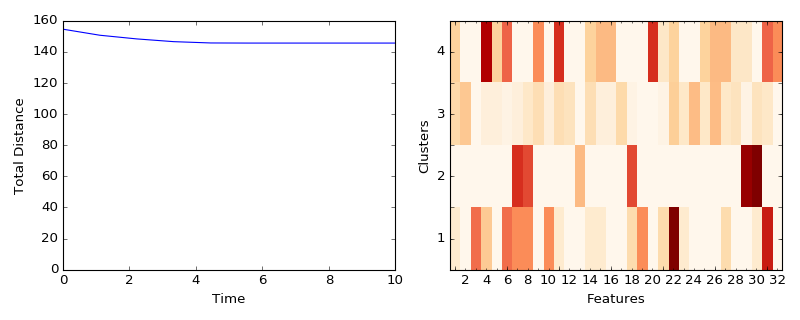

go (100, 1)
go (100, 1)
go (100, 1)
go (100, 1)
go (100, 1)
go (100, 1)
go (100, 1)
go (100, 1)
go (100, 1)
go (100, 1)
Final Distance: 145.736855


In [258]:
K = 4 # number of clusters
max_iters = 10 # number of iterations
X = transactions_np.T # transpose since algorithm assumes each entry is a row (not column)
initial_centroids = kMeansInitCentroids(X, K)
[centroids_k4, cluster_assignment_k4, di] = runkMeans(X, initial_centroids, max_iters, plot_progress=True)
print ("Final Distance: %f"%di)

Data Smart arrived at a distance of 140.7 using a K of 4, so our value is pretty close (143.5)

### Top Offers by Cluster (K=4)
Below each of the major deals in each cluster are sorted by how many samples (within the cluster) participated. 

In [220]:
top_offers = sorted_features(X,K,cluster_assignment_k4)

Below are the top deals for **Cluster 1**.
This matches Cluster 2 in the book which JF calls "Small Timers" because they are all small min qty.

In [221]:
order_info_df.loc[top_offers[0],:].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
Offer #,,,,,,
30.0,December,Malbec,6,54,France,False
8.0,March,Espumante,6,45,South Africa,False
7.0,March,Prosecco,6,40,Australia,True
29.0,November,Pinot Grigio,6,87,France,False
18.0,July,Espumante,6,50,Oregon,False


Below are the top deals for **Cluster 2**. 
This matches Cluster 3 in the book which JF calls a "bit of a mess". 

In [222]:
order_info_df.loc[top_offers[1],:].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
Offer #,,,,,,
22.0,August,Champagne,72,63,France,False
31.0,December,Champagne,72,89,France,False
4.0,February,Champagne,72,48,France,True
11.0,May,Champagne,72,85,France,False
14.0,June,Merlot,72,64,Chile,False


Below are the top deals for **Cluster 3**.
This matches Cluster 4 in the book which is heavy on Champagne.

In [223]:
order_info_df.loc[top_offers[2],:].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
Offer #,,,,,,
24.0,September,Pinot Noir,6,34,Italy,False
26.0,October,Pinot Noir,144,83,Australia,False
17.0,July,Pinot Noir,12,47,Germany,False
2.0,January,Pinot Noir,72,17,France,False
12.0,May,Prosecco,72,83,Australia,False


Below are the top deals for **Cluster 4**.
This matches Cluster 1 in the book which is heavy on Pinot Noir.

In [224]:
order_info_df.loc[top_offers[3],:].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
Offer #,,,,,,
20.0,August,Cabernet Sauvignon,72,82,Italy,False
32.0,December,Cabernet Sauvignon,72,45,Germany,True
11.0,May,Champagne,72,85,France,False
25.0,October,Cabernet Sauvignon,72,59,Oregon,True
4.0,February,Champagne,72,48,France,True


### An Aside.... 
In an attempt to verify the approach, below is a run using a simplified 2-D case of 100 points chosen to create 3 groups which where the centroids can be visually verified.

Note: in the plot below, the stars represent the initial centroids whereas the triangles and square are the final centroids

<IPython.core.display.Javascript object>


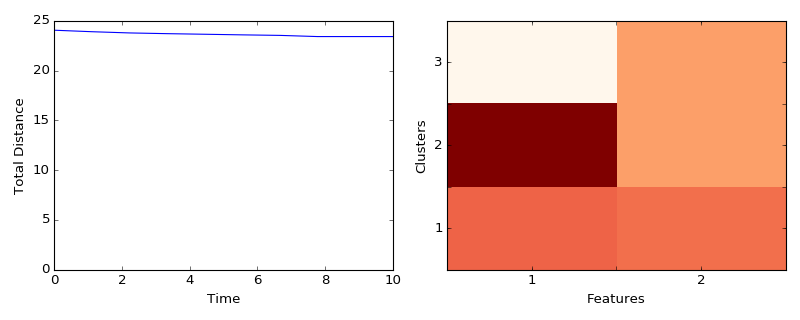

<IPython.core.display.Javascript object>


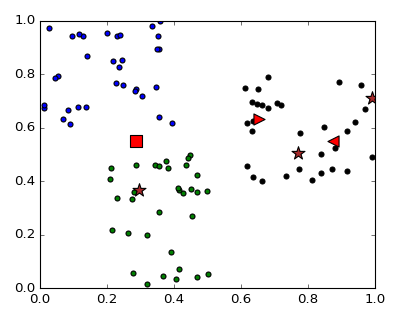

In [307]:
K = 3
max_iters = 10
test_data = np.zeros((100,2))
test_data[:33,0] = np.random.uniform(0, 0.4, 33) #cluster 1, x
test_data[:33,1] = np.random.uniform(0.6, 1, 33) #cluster 1, y
test_data[33:66,0] = np.random.uniform(.6, 1, 33) #cluster 2, x
test_data[33:66,1] = np.random.uniform(.4, 0.8, 33) #cluster 2, y
test_data[66:100,0] = np.random.uniform(0.2, 0.5, 34) #cluster 3, x
test_data[66:100,1] = np.random.uniform(0, 0.5, 34) #cluster 3, y
initial_centroids = kMeansInitCentroids(test_data, K)
[centroids_2Dtest, cluster_assignment_2Dtest, di] = runkMeans(test_data, initial_centroids, 
                                                              max_iters, plot_progress=True)

fig2 = plt.figure(figsize=(5, 4))
gs2 = gridspec.GridSpec(1, 1) 
ax2 = plt.subplot(gs2[0])
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.scatter(test_data[:33,0],test_data[:33,1],c='blue')
ax2.scatter(test_data[33:66,0],test_data[33:66,1],c='black')
ax2.scatter(test_data[66:100,0],test_data[66:100,1],c='green')
ax2.scatter(initial_centroids[:,0],initial_centroids[:,1],c='brown',s=150,marker='*')
sym = ['>','<','s']
for cl in range(K):
    ax2.scatter(centroids_2Dtest[cl,0],centroids_2Dtest[cl,1],c='red',s=100,marker=sym[cl])
plt.tight_layout()
fig2.canvas.draw()
time.sleep(.05)

### Silhouette

#### Silhouette Calculation


S<sub>i</sub> = (b<sub>i</sub>-a<sub>i</sub>)/max(a<sub>i</sub>, b<sub>i</sub>)
* a<sub>i</sub> = average distance of i to the points in its cluster
* b<sub>i</sub> = min-by-cluster (average distance of i to points in each other cluster)

Here is how to interpret the Silhouette Coefficient (SC):

  Range of SC   | Interpretation
  ------------- | -------------
  0.71 - 1.0    | A strong structure has been found
  0.51 - 0.70   | A reasonable structure has been found
  0.26 - 0.50   | The structure is weak and could be artificial
    < 0.25      | No substantial structure has been found 
A strong structure to the clusters indicates that most observations seem to belong to the cluster that they are in.

In [312]:
def distance_matrix(X):
    m, n = X.shape
    distance = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            distance[i,j] = np.sqrt(np.apply_along_axis(lambda x: x*x,0,X[j,:] - X[i,:]).sum())
    return distance

def silhouette_calc (distance_mat, cluster_assignment):
    m = distance_mat.shape[1]
    d_df = pd.DataFrame(distance_mat)
    ca_df = pd.DataFrame(cluster_assignment,columns=['C_A'])
    new_df = pd.concat((d_df,ca_df),axis=1)
    a = np.zeros((1,m))
    for i in range(m):
        this_cluster = cluster_assignment[i]
        a[0,i] = np.mean(new_df.iloc[:,i].where(new_df['C_A']==this_cluster[0],np.nan))
    b = np.zeros((K,m))
    for i in range(m):
        this_cluster = cluster_assignment[i]
        for j in range(K):
            if j != this_cluster:
                b[j,i] = np.mean(new_df.iloc[:,i].where(new_df['C_A']==j,np.nan))
            else:
                b[j,i] = np.nan
    b = np.nanmin(b,axis=0)
    b = np.reshape(b, (1,m))
    s = (b - a) / np.amax((a, b),axis=0)
    s = np.average(s)
    return s

In [313]:
distance_mat = distance_matrix(transactions_np.T)
silhouette  = silhouette_calc (distance_mat, cluster_assignment_k4)
print ("Silhouette (for K=4): %f"%silhouette)

Silhouette (for K=4): 0.133406


Data Smart calculated an SC of 0.1492, so we are close at 0.156.

### Rerun with K = 5

In [212]:
K = 5
max_iters = 10
initial_centroids = kMeansInitCentroids(transactions_np.T, K)
[centroids_k5, cluster_assignment_k5, di] = runkMeans(transactions_np.T, initial_centroids, 
                                                      max_iters, plot_progress=False)
distance_mat = distance_matrix(transactions_np)
silhouette  = silhouette_calc (distance_mat, cluster_assignment_k5)
print ("Final Distance: %f"%di)
print ("Silhouette (for K=5): %f"%silhouette)

Final Distance: 143.697547
Silhouette (for K=5): 0.053056


Data Smart got a distance of 135.075 and a silhouette of 0.134.

### Top Offers by Cluster (K=5)
Below each of the major deals in each cluster are sorted by how many samples (within the cluster) participated. 

In [213]:
top_offers = sorted_features(X,K,cluster_assignment_k5)

Below are the top deals for **Cluster 1**.

In [225]:
order_info_df.loc[top_offers[0],:].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
Offer #,,,,,,
30.0,December,Malbec,6,54,France,False
8.0,March,Espumante,6,45,South Africa,False
7.0,March,Prosecco,6,40,Australia,True
29.0,November,Pinot Grigio,6,87,France,False
18.0,July,Espumante,6,50,Oregon,False


Below are the top deals for **Cluster 2**.

In [226]:
order_info_df.loc[top_offers[1],:].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
Offer #,,,,,,
22.0,August,Champagne,72,63,France,False
31.0,December,Champagne,72,89,France,False
4.0,February,Champagne,72,48,France,True
11.0,May,Champagne,72,85,France,False
14.0,June,Merlot,72,64,Chile,False


Below are the top deals for **Cluster 3**.

In [227]:
order_info_df.loc[top_offers[2],:].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
Offer #,,,,,,
24.0,September,Pinot Noir,6,34,Italy,False
26.0,October,Pinot Noir,144,83,Australia,False
17.0,July,Pinot Noir,12,47,Germany,False
2.0,January,Pinot Noir,72,17,France,False
12.0,May,Prosecco,72,83,Australia,False


Below are the top deals for **Cluster 4**.

In [228]:
order_info_df.loc[top_offers[3],:].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
Offer #,,,,,,
20.0,August,Cabernet Sauvignon,72,82,Italy,False
32.0,December,Cabernet Sauvignon,72,45,Germany,True
11.0,May,Champagne,72,85,France,False
25.0,October,Cabernet Sauvignon,72,59,Oregon,True
4.0,February,Champagne,72,48,France,True


Below are the top deals for **Cluster 5**.

In [229]:
order_info_df.loc[top_offers[4],:].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
Offer #,,,,,,
32.0,December,Cabernet Sauvignon,72,45,Germany,True
31.0,December,Champagne,72,89,France,False
2.0,January,Pinot Noir,72,17,France,False
3.0,February,Espumante,144,32,Oregon,True
4.0,February,Champagne,72,48,France,True


## Rerun with K = 3

In [211]:
K = 3
max_iters = 10
initial_centroids = kMeansInitCentroids(transactions_np.T, K)
[centroids_k3, cluster_assignment_k3, di] = runkMeans(transactions_np.T, initial_centroids, 
                                                      max_iters, plot_progress=False)
distance_mat = distance_matrix(transactions_np)
silhouette  = silhouette_calc (distance_mat, cluster_assignment_k3)
print ("Final Distance: %f"%di)
print ("Silhouette (for K=5): %f"%silhouette)

Final Distance: 153.715495
Silhouette (for K=5): 0.072899


## Spherical k-means (cosine distance)

In [308]:
K = 5
max_iters = 20
initial_centroids = kMeansInitCentroids(transactions_np.T, K)
[centroids_k5_cos, cluster_assignment_k5_cos, di] = runkMeans(transactions_np.T, initial_centroids, 
                                                      max_iters, plot_progress=False, binary=True)
distance_mat = distance_matrix(transactions_np)
silhouette  = silhouette_calc (distance_mat, cluster_assignment_k5_cos)
print ("Final Distance: %f"%di)
print ("Silhouette (for K=5): %f"%silhouette)

Final Distance: 174.636647
Silhouette (for K=5): nan


/Users/lukestarnes/anaconda/envs/Py3.5/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:236: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


Data Smart got a distance of 42.84 and a silhouette of 0.172.

I am having an issue with the above binary-based approach. Every time it runs the samples quickly glom onto a small number of centroids (1 or 2) and it stabalizes. The reason for this seems to be in the way that the clusters get recomputed. When it goes to take the mean of each cluster in a group (to get a new set of centroids) it tends to get 0 for most features. This is due to the fact that the mean (per feature, aka deals) is the total number of samples (aka people) that belong to the feature (aka took the deal) divided by the number of samples (people) in the cluster. So, if 18 samples are in the cluster and 8 belong to a feature (took the deal) then that comes to 0.44, but since we are constrained to binary that becomes a 0 (makes sense -- more people didnt take the deal than did take it). With 100 samples and 5 clusters, we would expect nominally 20 samples per cluster. Across our 100 samples, the number of taken deals per sample is 3.24. So it makes sense that our centroids tend to converge on 0. Clearly something different needs to be done with the computeCentroids function. Its worth noting that this is not covered in Data Smart as the book uses Excel's solver to handle this piece. 

### K Clustering with SciKitLearn

SciKitLearn using the **KMeans** function with euclidean distance (similar to how we started at the top of this notebook).

In [364]:
from sklearn.cluster import KMeans
from sklearn import metrics

K = 5
max_iters = 100
X = transactions_np.T
m, n = X.shape

clusterer = KMeans(K, init='k-means++', n_init=50, max_iter=max_iters)
clusterer.fit_predict(X)
centroids_sk_k5 = clusterer.cluster_centers_
labels = clusterer.labels_ #Index of the cluster each sample belongs to.
cluster_assignment_k5_sk = labels.reshape(m, 1)

total_d = distance(X, centroids_sk_k5, K)
distance_mat = distance_matrix(transactions_np)
silhouette  = silhouette_calc (distance_mat, cluster_assignment_k5_sk)
silhouette2 = metrics.silhouette_score(X, labels, metric='euclidean',sample_size=m)
print ('Final Distance: %f'%(total_d))
print ("Silhouette (for K=5): %f"%silhouette)
print ("Silhouette (for K=5) (skl): %f"%silhouette2)

Final Distance: 137.456999
Silhouette (for K=5): 0.119278
Silhouette (for K=5) (skl): 0.126139


Note that the two silhouette calculations are not the same. Sometimes they are quite close and other times they are fairly different. This would need debugging if the algorithm implemented above was going to be reused.

SciKitLearn using the **AgglomerativeClustering** function with cosine distance (similar to the second approach used in this notebook).

In [353]:
from sklearn.cluster import AgglomerativeClustering

K = 5
max_iters = 10
X = transactions_np.T
m, n = X.shape

clusterer = AgglomerativeClustering(n_clusters=K,linkage="average", affinity='cosine')
clusterer.fit_predict(X)
centroids_sk_k5 = np.zeros((K, n))
labels = clusterer.labels_ #Index of the cluster each sample belongs to.
cluster_assignment_k5_sk = labels.reshape(m, 1)
for cluster in range(K):
    centroids_sk_k5[cluster] = X[np.where(cluster_assignment_k5_sk == cluster)[0]].mean(axis=0)

total_d = distance(X, centroids_sk_k5, K)
distance_mat = distance_matrix(transactions_np)
silhouette  = silhouette_calc (distance_mat, cluster_assignment_k5_sk)
print ('Final Distance: %f'%(total_d))
print ("Silhouette (for K=5): %f"%silhouette)

Final Distance: 138.349580
Silhouette (for K=5): 0.122908


Below the K-Means and Agglomerative approaches are each run on values of K from 2 to 15. Each run includes 100 iterations and is run 50 times. Of the 50 runs, the best run is reported. The results can be found below.

In [492]:
from sklearn.cluster import AgglomerativeClustering, KMeans

set_of_Ks = range(2,16)
max_iters = 100
X = transactions_np.T
m, n = X.shape
distance_mat = distance_matrix(transactions_np)
algos = ['km','agg']

results = np.zeros((len(set_of_Ks)*2,5))

for K in set_of_Ks:
    for i, t in enumerate(algos):
        if t == 'km':
            clusterer = KMeans(K, init='k-means++', n_init=50, max_iter=max_iters)
        else:
            clusterer = AgglomerativeClustering(K,linkage="average", affinity='cosine')                        
        clusterer.fit_predict(X)
        labels = clusterer.labels_ #Index of the cluster each sample belongs to.
        cluster_assignment = labels.reshape(m, 1)
        centroids = np.zeros((K, n))
        for cluster in range(K):
            centroids[cluster] = X[np.where(cluster_assignment == cluster)[0]].mean(axis=0)
        
        silhouette  = silhouette_calc (distance_mat, cluster_assignment)
        if t == 'km':
            silhouette2 = metrics.silhouette_score(X, labels, metric='euclidean',sample_size=m)
        else:
            silhouette2 = metrics.silhouette_score(X, labels, metric='cosine',sample_size=m)

        total_d = distance(X, centroids, K)
        results[(K-2)+(i*len(set_of_Ks))] = [K,i, silhouette, silhouette2, total_d]

results_df = pd.DataFrame(results,columns=['K','Algo','Silhouette (local)','Silhouette (skl)','Total Distance'])

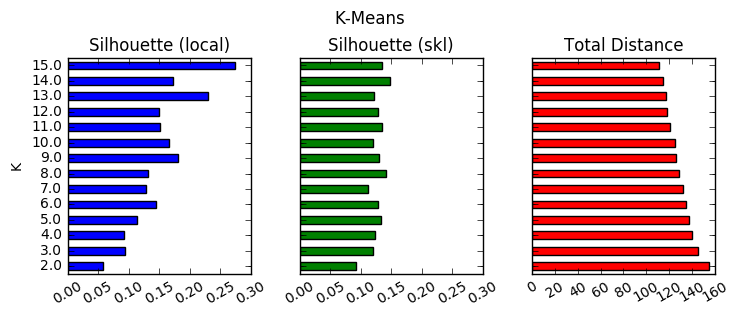

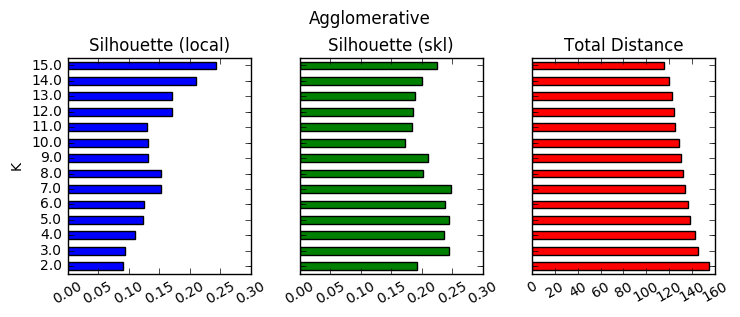

In [495]:
%matplotlib inline
results_km = results_df.where(results_df['Algo'] == 0).dropna().set_index('K',drop=True)
del results_km['Algo']
results_agg = results_df.where(results_df['Algo'] == 1).dropna().set_index('K',drop=True)
del results_agg['Algo']

km_plot = results_km.plot(kind='barh',subplots=True,legend=False,figsize=(7.5,3),
                          sharex=False,sharey=True,layout=(1,3),title='K-Means')
agg_plot = results_agg.plot(kind='barh',subplots=True,legend=False,figsize=(7.5,3),
                            sharex=False,sharey=True,layout=(1,3),title='Agglomerative')
x_lims = [plots.get_xlim()[1] for plots in km_plot[0]] + [plots.get_xlim()[1] for plots in agg_plot[0]]
x_lims[2] = 0
x_lims[5] = 0 # discounting the D graphs
max_x_lim = max(x_lims)
for plots in nd.hstack((km_plot,agg_plot))[0]:
    if plots.get_xlim()[1] <= max_x_lim:
        plots.set_xlim([0,max_x_lim])
    for t in plots.get_xticklabels():
        t.set_rotation(30)

km_fig = km_plot[0][0].get_figure()
agg_fig = agg_plot[0][0].get_figure()
km_fig.suptitle('K-Means', fontsize=12, x=0.5, y=1.04)
agg_fig.suptitle('Agglomerative', fontsize=12, x=0.5, y=1.04)
km_fig.tight_layout()
agg_fig.tight_layout()

 **What does this tell us?**
- The total distance steadily decreases as K gets bigger and it does not seem to vary between the two algorithsms.
- My calculation of silhouette and the skl calculation are in no way correlated. At this point I'm going to ignore the local (left-most graph) silhouette.
- Based on the skl silhouette, the Agglomerative (with cosine distance) perfoms better.
- Based on the skl silhouette, K = 7 provides the bet performance. this as a silhouette score of 0.248. Note that this is quite close to both K=3 and K=5 (0.24492 and 0.24488 respectivly). 

# Graph Silhouette vs K

For K = 3 The average silhouette_score is : 0.118102143979
For K = 4 The average silhouette_score is : 0.118899428636
For K = 5 The average silhouette_score is : 0.123470539196
For K = 6 The average silhouette_score is : 0.14092516242
For K = 8 The average silhouette_score is : 0.130920495649
For K = 10 The average silhouette_score is : 0.118736028013
For K = 12 The average silhouette_score is : 0.126401913769
For K = 14 The average silhouette_score is : 0.140012221243


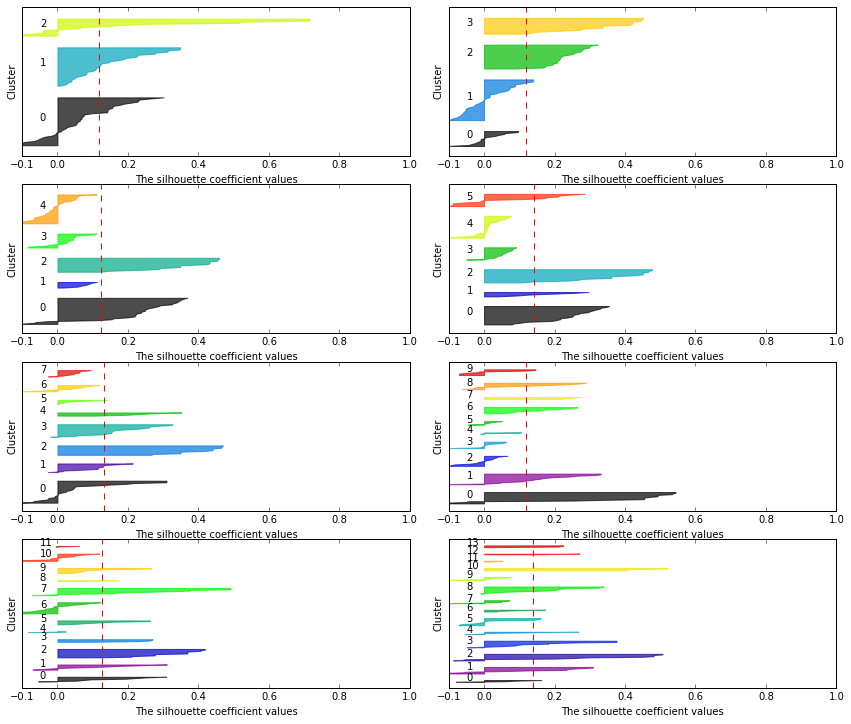

In [60]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# %matplotlib inline
range_n_clusters = [3, 4, 5, 6, 8, 10, 12, 14, 16]

s_per_K = np.zeros((1, len(range_n_clusters)))
counter = 0

fig, axs = plt.subplots(nrows=int(len(range_n_clusters)/2), ncols=2)
fig.set_size_inches(12,10) # w x h
plt.tight_layout()
for ax in axs.reshape(-1):
    if counter >= len(range_n_clusters): break # handles case of odd number of Ks
    n_clusters = range_n_clusters[counter]

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print("For K =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    s_per_K[0,counter] = silhouette_avg
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)


    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster")

    # The vertical line for average silhoutte score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    counter += 1

## Something Extra
### Detecting Click Clusters in Your Data Using Spreadsheet Math
* https://dl.dropboxusercontent.com/u/98476545/TNW_Click_Clusters.xlsx
* http://blog.mailchimp.com/detecting-click-clusters-in-your-data-using-spreadsheet-math/